# Playground series season 4, episode 1

The bank customer churn dataset is a commonly used dataset for predicting customer churn in the banking industry. It contains information on bank customers who either left the bank or continue to be a customer. The dataset includes the following attributes:

1. **Customer ID:** A unique identifier for each customer
2. **Surname:** The customer's surname or last name
3. **Credit Score:** A numerical value representing the customer's credit score
4. **Geography:** The country where the customer resides (France, Spain, or Germany)
5. **Gender:** The customer's gender (Male or Female)
6. **Age:** The customer's age.
7. **Tenure:** The number of years the customer has been with the bank
8. **Balance:** The customer's account balance
9. **NumOfProducts:** The number of bank products the customer uses (e.g., savings account, credit card)
10. **HasCrCard:** Whether the customer has a credit card (1 = yes, 0 = no)
11. **IsActiveMember:** Whether the customer is an active member (1 = yes, 0 = no)
12. **EstimatedSalary:** The estimated salary of the customer
13. **Exited:** Whether the customer has churned (1 = yes, 0 = no)

Load initial libraries:

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import PowerTransformer
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import StandardScaler

We load the initial dataset:

In [2]:
train = pd.read_csv('train.csv')
train.set_index('id',inplace = True)

In [3]:
train.head()

CustomerId         Surname  CreditScore Geography Gender   Age  Tenure  \
id                                                                           
0     15674932  Okwudilichukwu          668    France   Male  33.0       3   
1     15749177   Okwudiliolisa          627    France   Male  33.0       1   
2     15694510           Hsueh          678    France   Male  40.0      10   
3     15741417             Kao          581    France   Male  34.0       2   
4     15766172       Chiemenam          716     Spain   Male  33.0       5   

      Balance  NumOfProducts  HasCrCard  IsActiveMember  EstimatedSalary  \
id                                                                         
0        0.00              2        1.0             0.0        181449.97   
1        0.00              2        1.0             1.0         49503.50   
2        0.00              2        1.0             0.0        184866.69   
3   148882.54              1        1.0             1.0         84560.88   
4        0.00              2        1.0             1.0         15068.83   

    Exited  
id          
0        0  
1        0  
2        0  
3        0  
4        0

#### Training dataset imbalance

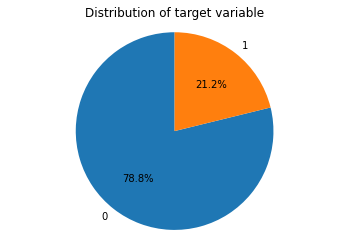

In [4]:
plt.pie(train.Exited.value_counts(),labels = train.Exited.value_counts().index, autopct='%1.1f%%', startangle=90)
plt.title('Distribution of target variable')
plt.axis('equal') 

plt.show()

#### NaN Counts

In [5]:
pd.DataFrame(train.isna().sum(), columns = ["NaN counts"])

NaN counts
CustomerId                0
Surname                   0
CreditScore               0
Geography                 0
Gender                    0
Age                       0
Tenure                    0
Balance                   0
NumOfProducts             0
HasCrCard                 0
IsActiveMember            0
EstimatedSalary           0
Exited                    0

# Numerical variables analysis

In [6]:
surname_freq = train['Surname'].value_counts(normalize=True).to_dict()

train['Surname'] = train['Surname'].map(surname_freq)

In [7]:
numerical_vars = ['Surname','CreditScore','Age','Tenure','Balance','NumOfProducts','EstimatedSalary']

train[numerical_vars].describe().transpose()

count           mean           std         min  \
Surname          165034.0       0.003233      0.003272    0.000006   
CreditScore      165034.0     656.454373     80.103340  350.000000   
Age              165034.0      38.125888      8.867205   18.000000   
Tenure           165034.0       5.020353      2.806159    0.000000   
Balance          165034.0   55478.086689  62817.663278    0.000000   
NumOfProducts    165034.0       1.554455      0.547154    1.000000   
EstimatedSalary  165034.0  112574.822734  50292.865585   11.580000   

                          25%            50%            75%            max  
Surname              0.000654       0.002193       0.004569       0.014882  
CreditScore        597.000000     659.000000     710.000000     850.000000  
Age                 32.000000      37.000000      42.000000      92.000000  
Tenure               3.000000       5.000000       7.000000      10.000000  
Balance              0.000000       0.000000  119939.517500  250898.090000  
NumOfProducts        1.000000       2.000000       2.000000       4.000000  
EstimatedSalary  74637.570000  117948.000000  155152.467500  199992.480000

## Variable Histograms

In [8]:
ncols = 3

# Calculate the number of rows needed based on the number of columns
nrows = -(-len(numerical_vars) // ncols)  # Ceiling division to get the number of rows

# Create subplots
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(15, 5 * nrows))

# Flatten the 2D array of subplots to a 1D array for easier indexing
axes = axes.flatten()

# Loop through variables and create histograms
for i, variable in enumerate(numerical_vars):
    ax = axes[i]
    bins = min([len(train[variable].value_counts()),15])
    sns.histplot(data = train, x = variable, ax=ax, bins = bins, hue = "Exited", hue_order = [0,1])
    ax.set_title(variable)
    ax.set_xlabel(variable)
    ax.set_ylabel('Frequency')

# Remove empty subplots
for j in range(i + 1, nrows * ncols):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

### Key takeaways

- All distributions seem reasonable. 
- Something to consider is that the mean age of both groups is different, so there are certains distribution differences in both groups which could label it as an important feature. 
- For Balance, there are many rows with 0 account balance, favoring the "0" class as the proportion is higher than in other bins.
- Higher NumOfProducts seem to be linked to the "1" class.

## Correlation Matrix

In [9]:
correlation_matrix = train[numerical_vars].corr(method = 'spearman')
mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))

plt.figure(figsize=(15, 6))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap="coolwarm", mask=mask)
plt.title('Triangular correlation matrix', size = 20)
plt.show()

## Key takeaways

- No outstanding correlations. Balance and NumOfProducts seem to be slightly inversely correlated.

## Pairplot

In [10]:
plt.figure(figsize=(12, 40))
pp = sns.pairplot(
    data = train[numerical_vars + ["Exited"]],
    hue='Exited',
    kind="scatter",
    diag_kind='kde',
    height=1.8,
    corner = True
);
pp.fig.suptitle("Variables pairplot", y=1.02, fontsize = 30)
plt.show()
plt.close()

<Figure size 864x2880 with 0 Axes>

### Key takeaways

- As discussed before, it seems that all variables crossed with age have datapoints corresponding to the "1" class in the mid-range, while for the "0" class they are more sparse.
- NumOfProducts show a higher density of the positive class in the higher values as well.

# Categorical variable analysis

In [11]:
train.head()

CustomerId   Surname  CreditScore Geography Gender   Age  Tenure  \
id                                                                     
0     15674932  0.001581          668    France   Male  33.0       3   
1     15749177  0.001818          627    France   Male  33.0       1   
2     15694510  0.007914          678    France   Male  40.0      10   
3     15741417  0.009556          581    France   Male  34.0       2   
4     15766172  0.001491          716     Spain   Male  33.0       5   

      Balance  NumOfProducts  HasCrCard  IsActiveMember  EstimatedSalary  \
id                                                                         
0        0.00              2        1.0             0.0        181449.97   
1        0.00              2        1.0             1.0         49503.50   
2        0.00              2        1.0             0.0        184866.69   
3   148882.54              1        1.0             1.0         84560.88   
4        0.00              2        1.0             1.0         15068.83   

    Exited  
id          
0        0  
1        0  
2        0  
3        0  
4        0

We will not consider CustomerId and Surname for this model for the following reasons:

- CustomerId does not correspond to increasing or decreasing trends. It might bias the model as to thinking certain values may impact negatively on output, and since it's an identifier column it does not explain the target variable.
- Surname might be of use if we track down variables such as country of origin, ethnicity or other relationship to it. It will not be considered for this model but a potential improvement could be to track this as well.

## Bar plots

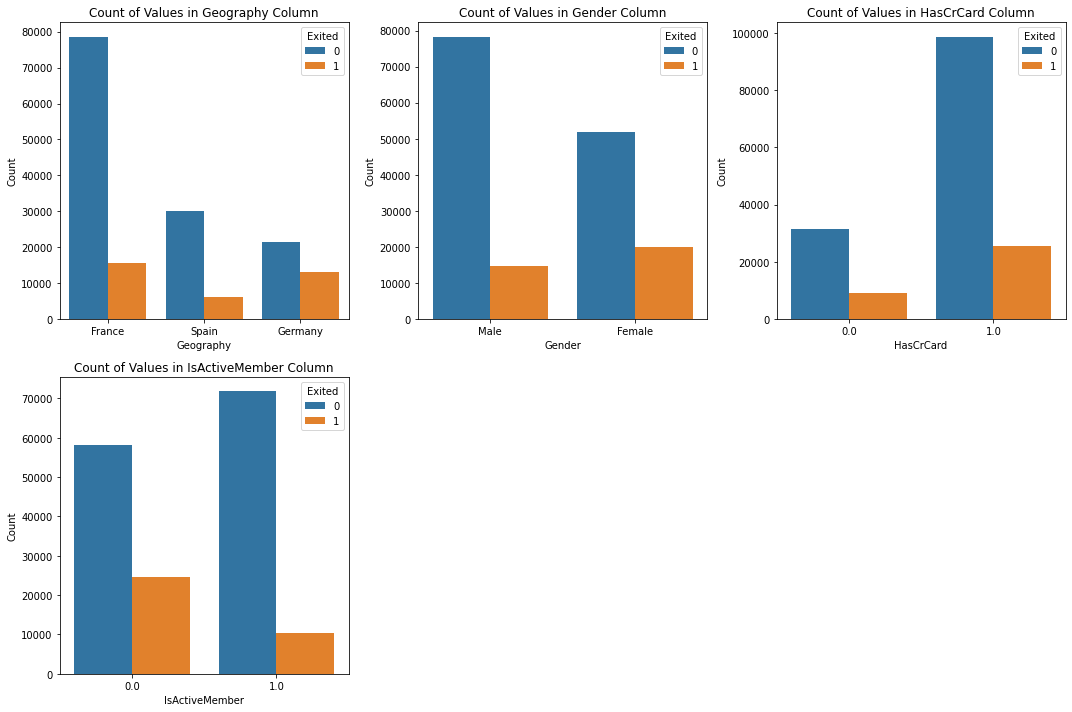

In [12]:
categorical_vars = ["Geography","Gender", "HasCrCard", "IsActiveMember"]

df_cat = train[categorical_vars]

ncols = 3

# Calculate the number of rows needed based on the number of columns
nrows = -(-len(df_cat.columns) // ncols)  # Ceiling division to get the number of rows

# Create subplots
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(15, 5 * nrows))

# Flatten the 2D array of subplots to a 1D array for easier indexing
axes = axes.flatten()

# Loop through columns and create bar plots
for i, column in enumerate(df_cat.columns):
    ax = axes[i]
    bars = sns.countplot(x=column, data=train, hue = "Exited", ax=ax, hue_order = [0, 1])
    
    ax.set_title(f'Count of Values in {column} Column')
    ax.set_xlabel(column)
    ax.set_ylabel('Count')

# Remove empty subplots
for j in range(i + 1, nrows * ncols):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

### Key takeaways

- Germany seems to be the more balanced of all countries across classes.
- Females show a lower difference between classes.
- HasCrCard does not seem to show much of a difference.
- IsActiveMember shows the 0 group to be more favorable for the "1" class.

# Train df build

Build binary features for categorical:

In [13]:
train_df = pd.get_dummies(train, columns = ["Gender","HasCrCard","IsActiveMember"],
                             prefix = ["Gender","HasCrCard","IsActiveMember"], drop_first = True)

train_df = pd.get_dummies(train_df, columns = ["Geography"],prefix = ["Geography"])

Drop unwanted features:

In [14]:
train_df.drop(["CustomerId"], axis = 1, inplace = True)

surname_freq_new = train_df['Surname'].value_counts().to_dict()

train_df['Surname'] = train_df['Surname'].map(surname_freq_new)

scaler = MinMaxScaler()

train_df[numerical_vars] = scaler.fit_transform(train_df[numerical_vars])

train_df.head()

Surname  CreditScore       Age  Tenure   Balance  NumOfProducts  \
id                                                                     
0   0.061019        0.636  0.202703     0.3  0.000000       0.333333   
1   0.171048        0.554  0.202703     0.1  0.000000       0.333333   
2   0.400195        0.656  0.297297     1.0  0.000000       0.333333   
3   1.000000        0.462  0.216216     0.2  0.593398       0.000000   
4   0.056151        0.732  0.202703     0.5  0.000000       0.333333   

    EstimatedSalary  Exited  Gender_Male  HasCrCard_1.0  IsActiveMember_1.0  \
id                                                                            
0          0.907279       0            1              1                   0   
1          0.247483       0            1              1                   1   
2          0.924364       0            1              1                   0   
3          0.422787       0            1              1                   1   
4          0.075293       0            1              1                   1   

    Geography_France  Geography_Germany  Geography_Spain  
id                                                        
0                  1                  0                0  
1                  1                  0                0  
2                  1                  0                0  
3                  1                  0                0  
4                  0                  0                1

In [15]:
train_df = train_df.astype('float64')
train_df.head()

Surname  CreditScore       Age  Tenure   Balance  NumOfProducts  \
id                                                                     
0   0.061019        0.636  0.202703     0.3  0.000000       0.333333   
1   0.171048        0.554  0.202703     0.1  0.000000       0.333333   
2   0.400195        0.656  0.297297     1.0  0.000000       0.333333   
3   1.000000        0.462  0.216216     0.2  0.593398       0.000000   
4   0.056151        0.732  0.202703     0.5  0.000000       0.333333   

    EstimatedSalary  Exited  Gender_Male  HasCrCard_1.0  IsActiveMember_1.0  \
id                                                                            
0          0.907279     0.0          1.0            1.0                 0.0   
1          0.247483     0.0          1.0            1.0                 1.0   
2          0.924364     0.0          1.0            1.0                 0.0   
3          0.422787     0.0          1.0            1.0                 1.0   
4          0.075293     0.0          1.0            1.0                 1.0   

    Geography_France  Geography_Germany  Geography_Spain  
id                                                        
0                1.0                0.0              0.0  
1                1.0                0.0              0.0  
2                1.0                0.0              0.0  
3                1.0                0.0              0.0  
4                0.0                0.0              1.0

# Colinearity

### Variance inflation factor analysis

In [16]:
from statsmodels.stats.outliers_influence import variance_inflation_factor 

cont_df = train_df

feats = cont_df.columns

vif_data = pd.DataFrame() 
vif_data["feature"] = feats
  
# calculating VIF for each feature 
vif_data["VIF"] = [variance_inflation_factor(cont_df.values, i) 
                          for i in range(len(feats))] 

vif_data.set_index("feature", inplace = True)

vif_data["VIF"] = vif_data["VIF"].apply(lambda x: format(x, '.4f'))
vif_data.sort_values(["VIF"], inplace = True)

vif_data

VIF
feature                    
Tenure               1.0006
CreditScore          1.0011
EstimatedSalary      1.0011
HasCrCard_1.0        1.0022
Surname              1.0058
Gender_Male          1.0224
IsActiveMember_1.0   1.0543
Age                  1.1413
NumOfProducts        1.2184
Exited               1.2996
Balance              1.6381
Geography_Germany   10.5977
Geography_France    22.8669
Geography_Spain      9.4221

### Key Takeaways

- There is no multicolinearity across features. 
- We are seeing multicolinearity for the geographical labeling, so it might be useful to remove one when modelling. We will assess this with a feature selection algorithm.

# Modelling

In [17]:
train_df

Surname  CreditScore       Age  Tenure   Balance  NumOfProducts  \
id                                                                         
0       0.061019        0.636  0.202703     0.3  0.000000       0.333333   
1       0.171048        0.554  0.202703     0.1  0.000000       0.333333   
2       0.400195        0.656  0.297297     1.0  0.000000       0.333333   
3       1.000000        0.462  0.216216     0.2  0.593398       0.000000   
4       0.056151        0.732  0.202703     0.5  0.000000       0.333333   
...          ...          ...       ...     ...       ...            ...   
165029  0.145083        0.634  0.202703     0.2  0.000000       0.000000   
165030  0.077897        0.884  0.229730     0.3  0.000000       0.000000   
165031  0.773450        0.430  0.175676     0.5  0.000000       0.000000   
165032  0.296981        0.408  0.162162     0.7  0.643819       0.000000   
165033  0.139890        1.000  0.175676     0.1  0.000000       0.000000   

        EstimatedSalary  Exited  Gender_Male  HasCrCard_1.0  \
id                                                            
0              0.907279     0.0          1.0            1.0   
1              0.247483     0.0          1.0            1.0   
2              0.924364     0.0          1.0            1.0   
3              0.422787     0.0          1.0            1.0   
4              0.075293     0.0          1.0            1.0   
...                 ...     ...          ...            ...   
165029         0.659179     0.0          0.0            1.0   
165030         0.659177     0.0          1.0            0.0   
165031         0.637151     0.0          1.0            1.0   
165032         0.355841     0.0          0.0            0.0   
165033         0.307880     1.0          1.0            1.0   

        IsActiveMember_1.0  Geography_France  Geography_Germany  \
id                                                                
0                      0.0               1.0                0.0   
1                      1.0               1.0                0.0   
2                      0.0               1.0                0.0   
3                      1.0               1.0                0.0   
4                      1.0               0.0                0.0   
...                    ...               ...                ...   
165029                 1.0               0.0                0.0   
165030                 0.0               1.0                0.0   
165031                 1.0               1.0                0.0   
165032                 1.0               0.0                0.0   
165033                 0.0               1.0                0.0   

        Geography_Spain  
id                       
0                   0.0  
1                   0.0  
2                   0.0  
3                   0.0  
4                   1.0  
...                 ...  
165029              1.0  
165030              0.0  
165031              0.0  
165032              1.0  
165033              0.0  

[165034 rows x 14 columns]

Import modelling tools.

In [18]:
from sklearn.ensemble import HistGradientBoostingClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier

from sklearn.metrics import roc_auc_score

from sklearn.model_selection import RepeatedStratifiedKFold

import lightgbm as lgb

We will try the following classifiers initially and go forward with the one providing the best results.

In [19]:
model_dict = {
    'Hist': HistGradientBoostingClassifier(verbose = 0),
    'XGB': XGBClassifier(),
    'LGBM' : LGBMClassifier(verbose=-1),
    'Cat' : CatBoostClassifier(logging_level='Silent')
}

In [20]:
def k_fold_validation(skf,model_dict,X,y):
    
    model_list, auroc_list=[],[]
    
    for model_name, model in model_dict.items():
        
        auroc_temp=[]
        
        for train_index,test_index in skf.split(X, y):
            
            X_train_fold, X_test_fold = X.iloc[train_index], X.iloc[test_index]
            Y_train_fold, Y_test_fold = y.iloc[train_index], y.iloc[test_index]
    
            model.fit(X_train_fold,Y_train_fold)
            y_pred = model.predict_proba(X_test_fold)[:,1]
    
            auroc_score = roc_auc_score(Y_test_fold, y_pred)
            auroc_temp.append(auroc_score)
            
        model_list.append(model_name)
        auroc_list.append(np.average(auroc_temp))
    return (pd.DataFrame({'Models': model_list, 'auroc_score': auroc_list}))

In [21]:
skf = RepeatedStratifiedKFold(n_splits=5, n_repeats =1, random_state=42)
k_fold_result = k_fold_validation(skf,model_dict,train_df.drop("Exited",axis = 1),train_df["Exited"])
k_fold_result.sort_values(by='auroc_score')

Models  auroc_score
1    XGB     0.888408
0   Hist     0.890223
2   LGBM     0.890401
3    Cat     0.891455

In [22]:
plt.figure(figsize = (8, 5))
plt.title('Model average performance')
sns.barplot(k_fold_result.sort_values(by='auroc_score', ascending = False), x='auroc_score', 
            y='Models',orient='h',width=0.6)

plt.show()

We see all of these perform similarly. We will trial these models below.

In [23]:
import optuna
optuna.logging.set_verbosity(optuna.logging.WARNING)

import warnings
warnings.filterwarnings("ignore")

from sklearn.model_selection import train_test_split

Split the datasets.

In [24]:
train = pd.read_csv('train.csv')
train.set_index('id',inplace = True)

In [25]:
train_df = pd.get_dummies(train, columns = ["Gender","HasCrCard","IsActiveMember"],
                             prefix = ["Gender","HasCrCard","IsActiveMember"], drop_first = True)

train_df = pd.get_dummies(train_df, columns = ["Geography"],prefix = ["Geography"])

In [26]:
train_df.drop(["CustomerId"], axis = 1, inplace = True)

train_df.head()

Surname  CreditScore   Age  Tenure    Balance  NumOfProducts  \
id                                                                        
0   Okwudilichukwu          668  33.0       3       0.00              2   
1    Okwudiliolisa          627  33.0       1       0.00              2   
2            Hsueh          678  40.0      10       0.00              2   
3              Kao          581  34.0       2  148882.54              1   
4        Chiemenam          716  33.0       5       0.00              2   

    EstimatedSalary  Exited  Gender_Male  HasCrCard_1.0  IsActiveMember_1.0  \
id                                                                            
0         181449.97       0            1              1                   0   
1          49503.50       0            1              1                   1   
2         184866.69       0            1              1                   0   
3          84560.88       0            1              1                   1   
4          15068.83       0            1              1                   1   

    Geography_France  Geography_Germany  Geography_Spain  
id                                                        
0                  1                  0                0  
1                  1                  0                0  
2                  1                  0                0  
3                  1                  0                0  
4                  0                  0                1

In [27]:
X_train, X_test, y_train, y_test = train_test_split(train_df.drop("Exited",axis = 1), train_df["Exited"],
                                                    test_size=0.2, random_state=42)

Run an Optuna iteration to find the best hyperparameters for optimizing on AUC score.

In [28]:
surname_freq_new = X_train['Surname'].value_counts().to_dict()

X_train['Surname'] = X_train['Surname'].map(surname_freq_new)

X_test['Surname'] = X_test['Surname'].map(surname_freq_new)

X_test['Surname'].fillna(min(surname_freq_new.values()), inplace=True)

X_train = X_train.astype('float64')
X_test = X_test.astype('float64')

In [29]:
def objective_scaling(trial):
    
    X_train_scaled = X_train.copy()
    X_test_scaled = X_test.copy()
    
    for col in numerical_vars:
        
        scale_trial = trial.suggest_categorical(
            col, ['minmax', 'power', 'robust', 'standard'])
        
        if scale_trial == 'minmax':
            scaler = MinMaxScaler()
        elif scale_trial == 'power':
            scaler = PowerTransformer()
        elif scale_trial == 'robust':
            scaler = RobustScaler()
        else:
            scaler = StandardScaler()
        
        X_train_scaled[col] = scaler.fit_transform(X_train_scaled[[col]])
        X_test_scaled[col] = scaler.transform(X_test_scaled[[col]])

    test_model = XGBClassifier()
    test_model.fit(X_train_scaled, y_train)

    score = roc_auc_score(y_test, test_model.predict_proba(X_test_scaled)[:, 1])
    return score

study_scaling = optuna.create_study(direction='maximize')
study_scaling.optimize(objective_scaling, n_trials=30, show_progress_bar=True)

  0%|          | 0/30 [00:00<?, ?it/s]

In [30]:
study_scaling.best_params

{'Surname': 'power',
 'CreditScore': 'minmax',
 'Age': 'standard',
 'Tenure': 'minmax',
 'Balance': 'power',
 'NumOfProducts': 'power',
 'EstimatedSalary': 'minmax'}

In [31]:
minmax_cols = [key for key, value in study_scaling.best_params.items() if value == 'minmax']
robust_cols = [key for key, value in study_scaling.best_params.items() if value == 'robust']
power_cols = [key for key, value in study_scaling.best_params.items() if value == 'power']
standard_cols = [key for key, value in study_scaling.best_params.items() if value == 'standard']

if len(minmax_cols) > 0:
    minmax_scaler = MinMaxScaler()
    X_train[minmax_cols] = minmax_scaler.fit_transform(X_train[minmax_cols])
    X_test[minmax_cols] = minmax_scaler.transform(X_test[minmax_cols])

if len(robust_cols) > 0:
    robust_scaler = RobustScaler()
    X_train[robust_cols] = robust_scaler.fit_transform(X_train[robust_cols])
    X_test[robust_cols] = robust_scaler.transform(X_test[robust_cols])

if len(power_cols) > 0:
    power_scaler = PowerTransformer()
    X_train[power_cols] = power_scaler.fit_transform(X_train[power_cols])
    X_test[power_cols] = power_scaler.transform(X_test[power_cols])
    
if len(standard_cols) > 0:
    standard_scaler = StandardScaler()
    X_train[standard_cols] = standard_scaler.fit_transform(X_train[standard_cols])
    X_test[standard_cols] = standard_scaler.transform(X_test[standard_cols])

# Modelling Trials

## LGBM Trial

In [32]:
def objective_lgbm(trial):
    lgb_params = {
        'objective': 'binary',
        'metric': 'auc', 
        'boosting_type': 'gbdt',
        'num_leaves': trial.suggest_int('num_leaves', 2, 128),
        'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.1),
        'n_estimators': trial.suggest_int('n_estimators', 100, 200, 500),
        'max_depth': trial.suggest_int('max_depth', 3, 20),
        'min_child_samples': trial.suggest_int('min_child_samples', 5, 100),
        'reg_alpha': trial.suggest_float('reg_alpha', 0.01, 1.0),
        'reg_lambda': trial.suggest_float('reg_lambda', 0.01, 1.0),
        'scale_pos_weight': trial.suggest_float('scale_pos_weight', 1, 10),
        'feature_fraction': trial.suggest_float('feature_fraction', 0.1, 1.0),
        'bagging_fraction': trial.suggest_float('bagging_fraction', 0.1, 1.0),
        'bagging_freq': trial.suggest_int('bagging_freq', 1, 10),
        'min_child_weight': trial.suggest_float('min_child_weight', 0.01, 1.0),
        'verbose': -1
    }

    lgb_model = LGBMClassifier(**lgb_params, random_state=42)
    lgb_model.fit(X_train, y_train)

    # Show the ROC AUC score directly
    score = roc_auc_score(y_test, lgb_model.predict_proba(X_test)[:, 1])
    return score

study_lgbm = optuna.create_study(direction='maximize')
study_lgbm.optimize(objective_lgbm, n_trials=30, show_progress_bar=True)

  0%|          | 0/30 [00:00<?, ?it/s]

In [33]:
lgbm_params = study_lgbm.best_params

lgbm_params['objective'] = 'binary'
lgbm_params['metric'] = 'auc' 
lgbm_params['boosting_type'] = 'gbdt'
lgbm_params['verbose'] = -1

Adjust the model to training data.

In [34]:
best_model = LGBMClassifier(**lgbm_params)

best_model.fit(X_train,y_train)

LGBMClassifier(bagging_fraction=0.678080804865637, bagging_freq=4,
               feature_fraction=0.7864158966045239,
               learning_rate=0.09533136628943469, max_depth=18, metric='auc',
               min_child_samples=88, min_child_weight=0.7424311239102418,
               num_leaves=83, objective='binary', reg_alpha=0.9997395093759971,
               reg_lambda=0.015478101204401185,
               scale_pos_weight=1.1392284331754334, verbose=-1)

Obtain the confusion matrix.

Train confusion matrix:


Train AUROC: 0.9116

Test confusion matrix:


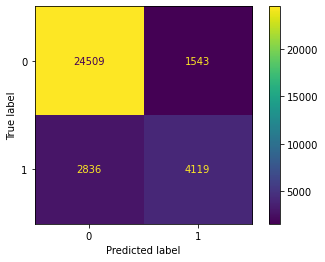


Test AUROC: 0.8942


In [35]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

print("Train confusion matrix:")

cm = confusion_matrix(y_train, pd.Series(best_model.predict(X_train),index = y_train.index))

conf_matrix = ConfusionMatrixDisplay(cm,display_labels = [0,1])

conf_matrix.plot()

plt.show()

predictions = best_model.predict(X_test)

print(f"Train AUROC: {roc_auc_score(y_train,best_model.predict_proba(X_train)[:,1]):.4f}")
print("")

print("Test confusion matrix:")

cm = confusion_matrix(y_test, pd.Series(predictions,index = y_test.index))

conf_matrix = ConfusionMatrixDisplay(cm,display_labels = [0,1])

conf_matrix.plot()

plt.show()

print("")
print(f"Test AUROC: {roc_auc_score(y_test,best_model.predict_proba(X_test)[:,1]):.4f}")

## Model feature importances

<Figure size 720x720 with 0 Axes>

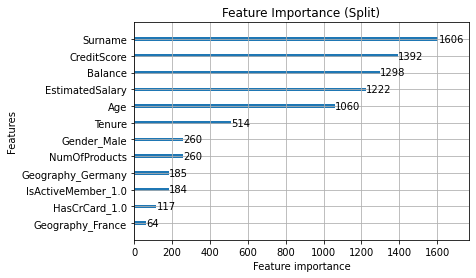

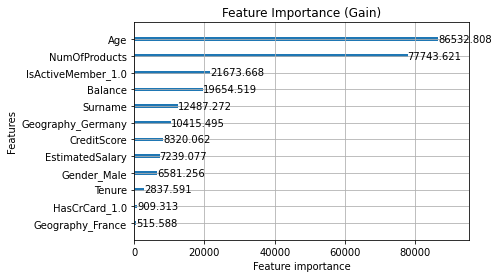

In [36]:
plt.figure(figsize = (10,10))

lgb.plot_importance(best_model, max_num_features=12, importance_type='split')
plt.title("Feature Importance (Split)")
plt.show()

lgb.plot_importance(best_model, max_num_features=12, importance_type='gain') 
plt.title("Feature Importance (Gain)")
plt.show()

### Key takeaways

- As discussed before, the main features showing up on the EDA reflect with the ones we are seeing here. We see that the geographical features don't seem to be adding much to the model at some point. Let's review the VIF values we obtained before:

In [37]:
vif_data

VIF
feature                    
Tenure               1.0006
CreditScore          1.0011
EstimatedSalary      1.0011
HasCrCard_1.0        1.0022
Surname              1.0058
Gender_Male          1.0224
IsActiveMember_1.0   1.0543
Age                  1.1413
NumOfProducts        1.2184
Exited               1.2996
Balance              1.6381
Geography_Germany   10.5977
Geography_France    22.8669
Geography_Spain      9.4221

Let's see how the model performs adding the top features sequentially:

In [38]:
def forward_feature_selection(X, y, model):
    selected_features = []
    best_score = 0

    while True:
        remaining_features = list(set(X.columns) - set(selected_features))

        if not remaining_features:
            break  # No remaining features to add

        scores = []

        for feature in remaining_features:
            candidate_features = selected_features + [feature]
            X_subset = X[candidate_features]

            X_train, X_test, y_train, y_test = train_test_split(X_subset, y, test_size=0.2, random_state=42)

            model.fit(X_train, y_train)
            y_pred = model.predict_proba(X_test)[:,1]

            score = roc_auc_score(y_test, y_pred)

            scores.append((feature, score))

        # Select the feature with the best score
        best_feature, best_score = max(scores, key=lambda x: x[1])

        # Add the best feature to the selected features
        selected_features.append(best_feature)
        
        print(f"Added feature: {best_feature}, Score: {best_score}")

    return selected_features

In [39]:
X_train

Surname  CreditScore       Age  Tenure   Balance  NumOfProducts  \
id                                                                         
149380  0.027907        0.658  0.324586     0.9 -0.918367       0.869986   
164766 -1.901008        0.742  0.888299     0.9  1.085284       0.869986   
155569 -0.385713        0.402 -0.351869     0.5 -0.918367      -1.044960   
124304 -0.607629        0.786 -0.802839     0.3  0.992701       0.869986   
108008 -0.702681        0.650 -1.141067     0.2 -0.918367       0.869986   
...          ...          ...       ...     ...       ...            ...   
119879  1.518044        0.636  0.775556     0.6  1.071891      -1.044960   
103694  1.518044        0.802  0.550071     0.7 -0.918367       0.869986   
131932  1.964669        0.806  0.099101     0.7 -0.918367       0.869986   
146867 -0.862543        0.670  1.113784     0.4 -0.918367       0.869986   
121958  0.152936        0.634 -0.351869     0.1  1.106043      -1.044960   

        EstimatedSalary  Gender_Male  HasCrCard_1.0  IsActiveMember_1.0  \
id                                                                        
149380         0.517796          1.0            1.0                 1.0   
164766         0.514745          1.0            1.0                 0.0   
155569         0.776989          1.0            1.0                 0.0   
124304         0.537135          0.0            1.0                 1.0   
108008         0.670561          1.0            1.0                 0.0   
...                 ...          ...            ...                 ...   
119879         0.565403          1.0            1.0                 0.0   
103694         0.444316          1.0            1.0                 0.0   
131932         0.839890          0.0            1.0                 0.0   
146867         0.124948          0.0            1.0                 1.0   
121958         0.700697          1.0            0.0                 0.0   

        Geography_France  Geography_Germany  Geography_Spain  
id                                                            
149380               1.0                0.0              0.0  
164766               1.0                0.0              0.0  
155569               1.0                0.0              0.0  
124304               0.0                0.0              1.0  
108008               1.0                0.0              0.0  
...                  ...                ...              ...  
119879               0.0                1.0              0.0  
103694               1.0                0.0              0.0  
131932               1.0                0.0              0.0  
146867               1.0                0.0              0.0  
121958               0.0                1.0              0.0  

[132027 rows x 13 columns]

In [40]:
features_forward = forward_feature_selection(X_train,y_train,
                                             LGBMClassifier(**lgbm_params))

Added feature: Age, Score: 0.7663770524899666
Added feature: NumOfProducts, Score: 0.8475096366693389
Added feature: IsActiveMember_1.0, Score: 0.8652070291502
Added feature: Balance, Score: 0.8738498992478584
Added feature: Geography_Germany, Score: 0.8820392090319926
Added feature: Gender_Male, Score: 0.8862702126695543
Added feature: Surname, Score: 0.8900969402828491
Added feature: HasCrCard_1.0, Score: 0.8909809923101937
Added feature: EstimatedSalary, Score: 0.8908425548454771
Added feature: Tenure, Score: 0.8910587124962273
Added feature: Geography_Spain, Score: 0.8904949264384993
Added feature: Geography_France, Score: 0.8901889344613365
Added feature: CreditScore, Score: 0.8898726045095727


We see that adding Geography_Spain/Geography_France as a feature does not improve the model and slightly impacts overall performance. We will therefore train the model and analyze the performance without any of these features.

In [41]:
X_train.drop("Geography_Spain", axis = 1, inplace = True)
X_test.drop("Geography_Spain", axis = 1, inplace = True)

In [42]:
best_model = LGBMClassifier(**lgbm_params)

best_model.fit(X_train,y_train)

LGBMClassifier(bagging_fraction=0.678080804865637, bagging_freq=4,
               feature_fraction=0.7864158966045239,
               learning_rate=0.09533136628943469, max_depth=18, metric='auc',
               min_child_samples=88, min_child_weight=0.7424311239102418,
               num_leaves=83, objective='binary', reg_alpha=0.9997395093759971,
               reg_lambda=0.015478101204401185,
               scale_pos_weight=1.1392284331754334, verbose=-1)

Train confusion matrix:


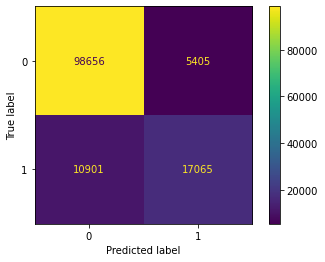

Train AUROC: 0.9114

Test confusion matrix:


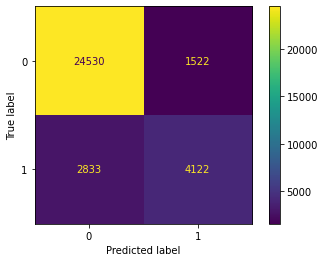


Test AUROC: 0.8945


In [43]:
print("Train confusion matrix:")

cm = confusion_matrix(y_train, pd.Series(best_model.predict(X_train),index = y_train.index))

conf_matrix = ConfusionMatrixDisplay(cm,display_labels = [0,1])

conf_matrix.plot()

plt.show()

predictions = best_model.predict(X_test)

print(f"Train AUROC: {roc_auc_score(y_train,best_model.predict_proba(X_train)[:,1]):.4f}")
print("")

print("Test confusion matrix:")

cm = confusion_matrix(y_test, pd.Series(predictions,index = y_test.index))

conf_matrix = ConfusionMatrixDisplay(cm,display_labels = [0,1])

conf_matrix.plot()

plt.show()

print("")
print(f"Test AUROC: {roc_auc_score(y_test,best_model.predict_proba(X_test)[:,1]):.4f}")

There is not much of a change as compared to the previous result. We'll use this model for simplification purposes.

## XGBoost Trial

In [44]:
def objective_xgb(trial):
    xgb_params = {
        'objective': 'binary:logistic',
        'booster': 'gbtree',
        'n_estimators': trial.suggest_int('n_estimators', 100, 500, 100),
        'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.1),
        'max_depth': trial.suggest_int('max_depth', 3, 20),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
        'subsample': trial.suggest_float('subsample', 0.1, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.1, 1.0),
        'reg_alpha': trial.suggest_float('reg_alpha', 0.01, 1.0),
        'reg_lambda': trial.suggest_float('reg_lambda', 0.01, 1.0),
        'scale_pos_weight': trial.suggest_float('scale_pos_weight', 1, 10),
        'gamma': trial.suggest_float('gamma', 0.01, 1.0),
        'verbosity': 0,
        'random_state': 42
    }

    xgb_model = XGBClassifier(**xgb_params)
    xgb_model.fit(X_train, y_train, eval_metric='auc', eval_set=[(X_test, y_test)], early_stopping_rounds=10, verbose=False)

    score = roc_auc_score(y_test, xgb_model.predict_proba(X_test)[:, 1])
    return score

study_xgb = optuna.create_study(direction='maximize')
study_xgb.optimize(objective_xgb, n_trials=30, show_progress_bar=True)

  0%|          | 0/30 [00:00<?, ?it/s]

In [45]:
xgb_params = study_xgb.best_params

xgb_params['objective'] = 'binary:logistic'
xgb_params['booster'] = 'gbtree' 
xgb_params['verbosity'] = 0
xgb_params['random_state'] = 42

Train confusion matrix:


Train AUROC: 0.9047

Test confusion matrix:


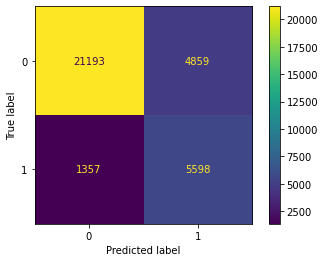


Test AUROC: 0.8953


In [46]:
best_model = XGBClassifier(**xgb_params, verbose = -1)

best_model.fit(X_train,y_train)

print("Train confusion matrix:")

cm = confusion_matrix(y_train, pd.Series(best_model.predict(X_train),index = y_train.index))

conf_matrix = ConfusionMatrixDisplay(cm,display_labels = [0,1])

conf_matrix.plot()

plt.show()

predictions = best_model.predict(X_test)

print(f"Train AUROC: {roc_auc_score(y_train,best_model.predict_proba(X_train)[:,1]):.4f}")
print("")

print("Test confusion matrix:")

cm = confusion_matrix(y_test, pd.Series(predictions,index = y_test.index))

conf_matrix = ConfusionMatrixDisplay(cm,display_labels = [0,1])

conf_matrix.plot()

plt.show()

print("")
print(f"Test AUROC: {roc_auc_score(y_test,best_model.predict_proba(X_test)[:,1]):.4f}")

### Key takeaway

- We see that it performs slightly better than the LGBM model based on AUC score, but has a higher False positive rate, while the LGBM model has a higher False Negative rate.

## HistGradientBoosting Trial

In [47]:
def objective_hist_gradient_boosting(trial):
    hist_params = {
        'loss': 'log_loss',
        'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.1),
        'max_iter': trial.suggest_int('max_iter', 100, 500, 100),
        'max_depth': trial.suggest_int('max_depth', 3, 20),
        'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 10),
        'max_leaf_nodes': trial.suggest_int('max_leaf_nodes', 31, 255),
        'l2_regularization': trial.suggest_float('l2_regularization', 0.0, 1.0),
        'max_bins': trial.suggest_int('max_bins', 2, 255),
        'random_state': 42
    }

    hist_model = HistGradientBoostingClassifier(**hist_params)
    hist_model.fit(X_train, y_train)

    # Show the ROC AUC score directly
    score = roc_auc_score(y_test, hist_model.predict_proba(X_test)[:, 1])
    return score

study_hist_gradient_boosting = optuna.create_study(direction='maximize')
study_hist_gradient_boosting.optimize(objective_hist_gradient_boosting, n_trials=30, show_progress_bar=True)

  0%|          | 0/30 [00:00<?, ?it/s]

In [48]:
hist_params = study_hist_gradient_boosting.best_params

hist_params['loss'] = 'log_loss'
hist_params['random_state'] = 42

Train confusion matrix:


Train AUROC: 0.9024

Test confusion matrix:


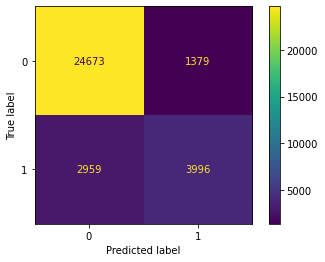


Test AUROC: 0.8946


In [49]:
best_model = HistGradientBoostingClassifier(**hist_params)

best_model.fit(X_train,y_train)

print("Train confusion matrix:")

cm = confusion_matrix(y_train, pd.Series(best_model.predict(X_train),index = y_train.index))

conf_matrix = ConfusionMatrixDisplay(cm,display_labels = [0,1])

conf_matrix.plot()

plt.show()

predictions = best_model.predict(X_test)

print(f"Train AUROC: {roc_auc_score(y_train,best_model.predict_proba(X_train)[:,1]):.4f}")
print("")

print("Test confusion matrix:")

cm = confusion_matrix(y_test, pd.Series(predictions,index = y_test.index))

conf_matrix = ConfusionMatrixDisplay(cm,display_labels = [0,1])

conf_matrix.plot()

plt.show()

print("")
print(f"Test AUROC: {roc_auc_score(y_test,best_model.predict_proba(X_test)[:,1]):.4f}")

## Catboost trial

In [50]:
def objective_catboost(trial):
    cat_params = {
        'iterations': trial.suggest_int('iterations', 100, 500, 100),
        'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.1),
        'depth': trial.suggest_int('depth', 3, 10),
        'l2_leaf_reg': trial.suggest_float('l2_leaf_reg', 0.01, 1.0),
        'border_count': trial.suggest_int('border_count', 1, 255),
        'bagging_temperature': trial.suggest_float('bagging_temperature', 0.0, 1.0),
        'random_strength': trial.suggest_float('random_strength', 0.0, 1.0),
        'scale_pos_weight': trial.suggest_float('scale_pos_weight', 1, 10),
        'eval_metric': 'AUC',
        'verbose': False,
        'random_state': 42
    }

    cat_model = CatBoostClassifier(**cat_params)
    cat_model.fit(X_train, y_train, eval_set=(X_test, y_test), early_stopping_rounds=10, verbose_eval=False)

    score = roc_auc_score(y_test, cat_model.predict_proba(X_test)[:, 1])
    return score

study_catboost = optuna.create_study(direction='maximize')
study_catboost.optimize(objective_catboost, n_trials=30, show_progress_bar=True)

  0%|          | 0/30 [00:00<?, ?it/s]

In [51]:
cat_params = study_catboost.best_params

cat_params['eval_metric'] = 'AUC'
cat_params['verbose'] = False
cat_params['random_state'] = 42

Train confusion matrix:


Train AUROC: 0.9038

Test confusion matrix:


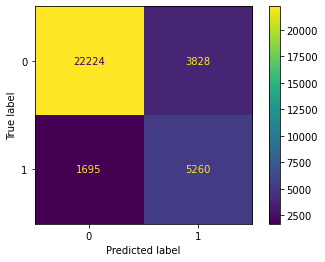


Test AUROC: 0.8942


In [52]:
best_model = CatBoostClassifier(**cat_params)

best_model.fit(X_train,y_train)

print("Train confusion matrix:")

cm = confusion_matrix(y_train, pd.Series(best_model.predict(X_train),index = y_train.index))

conf_matrix = ConfusionMatrixDisplay(cm,display_labels = [0,1])

conf_matrix.plot()

plt.show()

predictions = best_model.predict(X_test)

print(f"Train AUROC: {roc_auc_score(y_train,best_model.predict_proba(X_train)[:,1]):.4f}")
print("")

print("Test confusion matrix:")

cm = confusion_matrix(y_test, pd.Series(predictions,index = y_test.index))

conf_matrix = ConfusionMatrixDisplay(cm,display_labels = [0,1])

conf_matrix.plot()

plt.show()

print("")
print(f"Test AUROC: {roc_auc_score(y_test,best_model.predict_proba(X_test)[:,1]):.4f}")

### Key takeaway

- All models have a very similar performance. We'll run an iteration with a voting classifier.

## Voting ensemble classifier

In [53]:
from sklearn.ensemble import VotingClassifier

estimators = [
    ('LGBM', LGBMClassifier(**lgbm_params)),
    ('XGBC', XGBClassifier(**xgb_params)),
    ('CatB', CatBoostClassifier(**cat_params)),
    ('HistGB', HistGradientBoostingClassifier(**hist_params))
]

def objective_voting(trial):
    vote_params = {
        'voting': 'soft',
        'weights': [trial.suggest_float('weight_model1', 0.0, 1.0),
                     trial.suggest_float('weight_model2', 0.0, 1.0),
                     trial.suggest_float('weight_model3', 0.0, 1.0),
                   trial.suggest_float('weight_model4', 0.0, 1.0)]
    }

    vote_model = VotingClassifier(estimators,**vote_params)
    vote_model.fit(X_train, y_train)

    score = roc_auc_score(y_test, vote_model.predict_proba(X_test)[:, 1])
    return score

study_vote = optuna.create_study(direction='maximize')
study_vote.optimize(objective_voting, n_trials=20, show_progress_bar=True)

  0%|          | 0/20 [00:00<?, ?it/s]

In [54]:
best_model = VotingClassifier(estimators,weights = list(study_vote.best_params.values()),voting = 'soft')

print(study_vote.best_params)

best_model.fit(X_train,y_train)

{'weight_model1': 0.707388404059378, 'weight_model2': 0.6660278093792131, 'weight_model3': 0.017302599456450074, 'weight_model4': 0.32548649438598326}


VotingClassifier(estimators=[('LGBM',
                              LGBMClassifier(bagging_fraction=0.678080804865637,
                                             bagging_freq=4,
                                             feature_fraction=0.7864158966045239,
                                             learning_rate=0.09533136628943469,
                                             max_depth=18, metric='auc',
                                             min_child_samples=88,
                                             min_child_weight=0.7424311239102418,
                                             num_leaves=83, objective='binary',
                                             reg_alpha=0.9997395093759971,
                                             reg_lambda=0.015478101204401185,
                                             s...
                              <catboost.core.CatBoostClassifier object at 0x0000025909C63E50>),
                             ('HistGB',
                              HistGradientBoostingClassifier(l2_regularization=0.6081603647588417,
                                                             learning_rate=0.07238018535007539,
                                                             max_bins=221,
                                                             max_depth=5,
                                                             max_iter=500,
                                                             max_leaf_nodes=240,
                                                             min_samples_leaf=4,
                                                             random_state=42))],
                 voting='soft',
                 weights=[0.707388404059378, 0.6660278093792131,
                          0.017302599456450074, 0.32548649438598326])

Train confusion matrix:


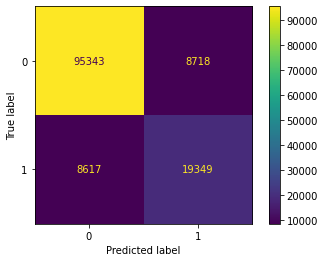

Train AUROC: 0.9077

Test confusion matrix:


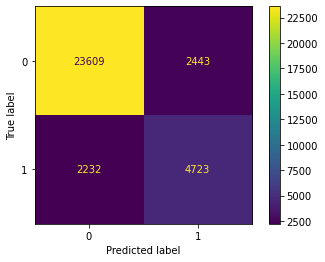


Test AUROC: 0.8956


In [55]:
print("Train confusion matrix:")

cm = confusion_matrix(y_train, pd.Series(best_model.predict(X_train),index = y_train.index))

conf_matrix = ConfusionMatrixDisplay(cm,display_labels = [0,1])

conf_matrix.plot()

plt.show()

predictions = best_model.predict(X_test)

print(f"Train AUROC: {roc_auc_score(y_train,best_model.predict_proba(X_train)[:,1]):.4f}")
print("")

print("Test confusion matrix:")

cm = confusion_matrix(y_test, pd.Series(predictions,index = y_test.index))

conf_matrix = ConfusionMatrixDisplay(cm,display_labels = [0,1])

conf_matrix.plot()

plt.show()

print("")
print(f"Test AUROC: {roc_auc_score(y_test,best_model.predict_proba(X_test)[:,1]):.4f}")

# Test

In [56]:
test = pd.read_csv('test.csv')
test.set_index('id',inplace = True)

In [57]:
test_df = pd.get_dummies(test, columns = ["Gender","HasCrCard","IsActiveMember"],
                             prefix = ["Gender","HasCrCard","IsActiveMember"], drop_first = True)

test_df = pd.get_dummies(test_df, columns = ["Geography"],prefix = ["Geography"])
test_df.drop("Geography_Spain", axis = 1, inplace = True)

test_df.drop(["CustomerId"], axis = 1, inplace = True)

In [58]:
test_df['Surname'] = test_df['Surname'].map(surname_freq_new)

test_df['Surname'].fillna(min(surname_freq_new.values()), inplace=True)

In [60]:
if len(minmax_cols) > 0:
    test_df[minmax_cols] = minmax_scaler.transform(test_df[minmax_cols])

if len(robust_cols) > 0:
    test_df[robust_cols] = robust_scaler.transform(test_df[robust_cols])

if len(power_cols) > 0:
    test_df[power_cols] = power_scaler.transform(test_df[power_cols])
    
if len(standard_cols) > 0:
    test_df[standard_cols] = standard_scaler.transform(test_df[standard_cols])

In [61]:
test_df = test_df.astype('float64')

test_df.head()

Surname  CreditScore       Age  Tenure   Balance  NumOfProducts  \
id                                                                         
165034  0.407407    -0.699056 -4.490058    0.02 -0.918367       0.869986   
165035 -1.620534    -0.698668 -4.197708    0.02 -0.918367      -1.044960   
165036  0.558331    -0.698776 -4.350239    0.07 -0.918367       0.869986   
165037  0.212943    -0.698676 -4.324817    0.08 -0.918367      -1.044960   
165038 -1.706679    -0.698392 -4.299395    0.10  1.091381      -1.044960   

        EstimatedSalary  Gender_Male  HasCrCard_1.0  IsActiveMember_1.0  \
id                                                                        
165034        -0.000054          0.0            0.0                 1.0   
165035        -0.000056          0.0            1.0                 0.0   
165036        -0.000054          0.0            1.0                 0.0   
165037        -0.000055          1.0            1.0                 0.0   
165038        -0.000054          1.0            1.0                 0.0   

        Geography_France  Geography_Germany  
id                                           
165034               1.0                0.0  
165035               1.0                0.0  
165036               1.0                0.0  
165037               1.0                0.0  
165038               0.0                1.0

In [62]:
test["Exited"] = best_model.predict_proba(test_df)[:,1]

In [63]:
test.reset_index()[["id","Exited"]].to_parquet("Submission.csv",index = False)